In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras import layers, losses
from keras.models import Sequential
from keras.optimizers import Adam

In [2]:
try:
    # enable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type == 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [3]:
DATA_DIR_SLOW = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaSlow.npy"
DATA_DIR_NORMAL = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaNormal.npy"
DATA_DIR_C_NAMES = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaColumnNames.npy"

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [4]:
data_normal = np.load(DATA_DIR_NORMAL)
data_slow = np.load(DATA_DIR_SLOW)
column_names = np.load(DATA_DIR_C_NAMES)

In [5]:
print(column_names)

['action' 'machine_nameKuka Robot_apparent_power'
 'machine_nameKuka Robot_current' 'machine_nameKuka Robot_frequency'
 'machine_nameKuka Robot_phase_angle' 'machine_nameKuka Robot_power'
 'machine_nameKuka Robot_power_factor'
 'machine_nameKuka Robot_reactive_power' 'machine_nameKuka Robot_voltage'
 'sensor_id1_AccX' 'sensor_id1_AccY' 'sensor_id1_AccZ' 'sensor_id1_GyroX'
 'sensor_id1_GyroY' 'sensor_id1_GyroZ' 'sensor_id1_q1' 'sensor_id1_q2'
 'sensor_id1_q3' 'sensor_id1_q4' 'sensor_id1_temp' 'sensor_id2_AccX'
 'sensor_id2_AccY' 'sensor_id2_AccZ' 'sensor_id2_GyroX' 'sensor_id2_GyroY'
 'sensor_id2_GyroZ' 'sensor_id2_q1' 'sensor_id2_q2' 'sensor_id2_q3'
 'sensor_id2_q4' 'sensor_id2_temp' 'sensor_id3_AccX' 'sensor_id3_AccY'
 'sensor_id3_AccZ' 'sensor_id3_GyroX' 'sensor_id3_GyroY'
 'sensor_id3_GyroZ' 'sensor_id3_q1' 'sensor_id3_q2' 'sensor_id3_q3'
 'sensor_id3_q4' 'sensor_id3_temp' 'sensor_id4_AccX' 'sensor_id4_AccY'
 'sensor_id4_AccZ' 'sensor_id4_GyroX' 'sensor_id4_GyroY'
 'sensor_id4_GyroZ

In [6]:
# Get labels from data slow
label_slow = data_slow[:,-1:]
data_slow = data_slow[:,:-1]

In [7]:
# Normalization train on train set transform both
scaler = preprocessing.StandardScaler().fit(data_normal)
data_train_scaled = scaler.transform(data_normal)
data_test_scaled = scaler.transform(data_slow) #

In [8]:
#windows of 50 with stride 1
width_window = 48
data_train_all = np.array([data_train_scaled[i:i+width_window,:] for i in range(0, len(data_train_scaled)-width_window)])
data_test_all = np.array([data_test_scaled[i:i+width_window,:] for i in range(0, len(data_test_scaled)-width_window)])
print(f"train data shape: {data_train_all.shape} \n test data shape: {data_test_all.shape} ")

train data shape: (233744, 48, 86) 
 test data shape: (41490, 48, 86) 


In [9]:
percentage = 0.10
N = 4

# take part of data to gather results faster
data_train = data_train_all[0:int(percentage*data_train_all.shape[0]),:,:]
data_test = data_test_all[0:int(percentage*data_test_all.shape[0]),:,:]

# mixed test data 50-50
data_test_mixed = np.zeros((2*data_test.shape[0], data_test.shape[1], data_test.shape[2]))
data_test_mixed[0:int(data_test.shape[0]),:,:] += data_test
data_test_mixed[int(data_test.shape[0]):,:,:] += data_train[-int(data_test.shape[0]):,:,:]

# set labels
label_test = label_slow[0:data_test.shape[0]]
label_test_mixed = np.zeros((data_test_mixed.shape[0], 1))
label_test_mixed[0:label_test.shape[0]] += label_test

# Validation data
data_validation = data_train_all[int(percentage*data_train_all.shape[0]*N): int(percentage*data_train_all.shape[0]*(N+0.1)),:,:]


print(f"train data shape: {data_train.shape} \ntest data shape: {data_test.shape} \nlabel shape: {label_test.shape} \n\ntest data prepared: {data_test_mixed.shape} \nlabel prepared: {label_test_mixed.shape} \n\ndata validation: {data_validation.shape}")

train data shape: (23374, 48, 86) 
test data shape: (4149, 48, 86) 
label shape: (4149, 1) 

test data prepared: (8298, 48, 86) 
label prepared: (8298, 1) 

data validation: (2338, 48, 86)


In [11]:
# Run if you want ram to free
data_train_all = 0
data_test_all = 0

Next, the models for Encoder, Decoder and Discriminator (the adversarial opponent) are defined:

In [12]:
data_train = data_train.reshape(data_train.shape[0], data_train.shape[1], data_train.shape[2], 1)
data_test = data_test.reshape(data_test.shape[0], data_test.shape[1], data_test.shape[2], 1)
data_validation = data_validation.reshape(data_validation.shape[0], data_validation.shape[1], data_validation.shape[2], 1)

In [14]:
# def make_encoder_model(z_size):
#     inputs = tf.keras.layers.Input(shape=input_shape)
#     print(f"encoder input: {inputs.shape}")
#     x = layers.Conv1D(32, 5, padding="same", activation="relu", input_shape=input_shape)(inputs)
#     x = layers.Conv1D(64, 5, strides=2, activation="relu", padding="same")(x)
#     x = layers.Conv1D(128, 5, strides=2, activation="relu", padding="same")(x)
#     x = layers.Flatten()(x)
#     z = layers.Dense(z_size, activation="linear")(x)
#     print(f"endoder output: {z.shape}")
#
#     model = tf.keras.Model(inputs=inputs, outputs=z)
#     return model
#
# def make_decoder_model(z_size):
#     encoded = tf.keras.Input(shape=z_size)
#     print(f"decoder input: {encoded.shape}")
#
#     x = layers.Dense(12*23*128)(encoded)
#     x = layers.Reshape((12, 23, 128))(x)
#     x = layers.Conv1D(64, 5, activation="relu", padding="same")(x)
#     x = layers.UpSampling2D()(x)
#     x = layers.Conv1D(32, 5, activation="relu", padding="same")(x)
#     x = layers.UpSampling2D()(x)
#     reconstruction = layers.Conv1D(1, 7, activation="sigmoid")(x)
#
#     print(f"decoder output: {reconstruction.shape}")
#     decoder = tf.keras.Model(inputs=encoded, outputs=reconstruction)
#     return decoder
#
# def make_discriminator_model(z_size):
#     encoded = tf.keras.Input(shape=(z_size))
#     print(f"discriminator input: {encoded.shape}")
#     x = layers.Dense(63, activation="relu", input_shape=(1, latent_shape))(encoded)
#     x = layers.Dense(32, activation="relu")(x)
#     x = layers.Dense(1, activation="sigmoid")(x)
#     prediction = tf.keras.layers.LeakyReLU(0.2)(x)
#     print(f"discriminator output: {prediction.shape}")
#     model = tf.keras.Model(inputs=encoded, outputs=prediction)
#     return model
#
# z_dim = 2
# encoder = make_encoder_model(z_dim)
# decoder = make_decoder_model(z_dim)
# discriminator = make_discriminator_model(z_dim)

encoder input: (None, 48, 86, 1)
endoder output: (None, 2)
decoder input: (None, 2)
decoder output: (None, 48, 86, 1)
discriminator input: (None, 2)
discriminator output: (None, 1)


In [19]:
input_shape = data_train.shape[1:]
latent_shape = 4

In [20]:
def build_model_enc():
    model = Sequential()
    model.add(layers.Conv1D(32, 5, padding="same", activation="relu", input_shape=input_shape))
    model.add(layers.Conv1D(64, 5, strides=2, activation="relu", padding="same"))
    model.add(layers.Conv1D(128, 5, strides=2, activation="relu", padding="same"))
    model.add(layers.Flatten())
    model.add(layers.Dense(latent_shape, activation="linear"))

    return model

def build_model_dec():
    model = Sequential()
    model.add(layers.Dense(12*23*128, input_shape=(latent_shape, )))
    model.add(layers.Reshape((12, 23, 128)))
    model.add(layers.Conv1D(64, 5, activation="relu", padding="same"))
    model.add(layers.UpSampling2D())
    model.add(layers.Conv1D(32, 5, activation="relu", padding="same"))
    model.add(layers.UpSampling2D())
    model.add(layers.Conv1D(1, 7, activation="sigmoid"))

    return model

def build_model_disc():
    model = Sequential()
    model.add(layers.Dense(63, activation="relu", input_shape=(latent_shape, )))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))
    return model

In [21]:
def build_model_aae():
    model_enc = build_model_enc()
    model_dec = build_model_dec()
    model_disc = build_model_disc()

    model_ae = Sequential()
    model_ae.add(model_enc)
    model_ae.add(model_dec)

    model_enc_disc = Sequential()
    model_enc_disc.add(model_enc)
    model_enc_disc.add(model_disc)

    return model_enc, model_dec, model_disc, model_ae, model_enc_disc

model_enc, model_dec, model_disc, model_ae, model_enc_disc = build_model_aae()

model_enc.summary()
model_dec.summary()
model_disc.summary()
model_ae.summary()
model_enc_disc.summary()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()

model_disc.compile(optimizer=Adam(learning_rate=1e-5), loss=cross_entropy)
model_enc_disc.compile(optimizer=Adam(learning_rate=1e-5), loss=cross_entropy)
model_ae.compile(optimizer=Adam(learning_rate=1e-5), loss=mse)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 48, 86, 32)        192       
                                                                 
 conv1d_13 (Conv1D)          (None, 48, 43, 64)        10304     
                                                                 
 conv1d_14 (Conv1D)          (None, 48, 22, 128)       41088     
                                                                 
 flatten_2 (Flatten)         (None, 135168)            0         
                                                                 
 dense_10 (Dense)            (None, 4)                 540676    
                                                                 
Total params: 592,260
Trainable params: 592,260
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_6"
__________________________

The Models are put together in the required combinations and compiled

Some helper functions to facilitate training and give a nice overview of the 2 dimensional latent space are defined.

In [22]:
def settrainable(model, toset):
    for layer in model.layers:
        layer.trainable = toset
    model.trainable = toset

The Model is trained in the following steps for each minibatch:
    1) The Autoencoder is trained
    2) The Discriminator is trained to differentiate between z from images and the distribution we want z to have (normal distribution in this case)
    3) The Encoder is trained to fool the parameter-fixed discriminator into thinking the z are real

In [24]:
test_cost = []
train_cost = []
validation_cost = []

batch_size = 512
number_epoch = 10
#Set Number of Epochs to 10-20 or higher.
for epoch_number in range(number_epoch):
    
    for i in range(int(len(data_train) / batch_size)):
        settrainable(model_ae, True)
        settrainable(model_enc, True)
        settrainable(model_dec, True)
        
        batch = data_train[i*batch_size:i*batch_size+batch_size]
        model_ae.train_on_batch(batch, batch)
        
        settrainable(model_disc, True)
        batch_pred = model_enc.predict(batch)
        fake_pred = np.random.standard_normal((batch_size, latent_shape))
        disc_batch_x = np.concatenate([batch_pred, fake_pred])
        disc_batch_y = np.concatenate([np.zeros(batch_size), np.ones(batch_size)])
        model_disc.train_on_batch(disc_batch_x, disc_batch_y)
        
        settrainable(model_enc_disc, True)
        settrainable(model_enc, True)
        settrainable(model_disc, False)
        model_enc_disc.train_on_batch(batch, np.ones(batch_size))
    
    print ("Reconstruction Loss:", model_ae.evaluate(data_train, data_train, verbose=0))
    print ("Adverserial Loss:", model_enc_disc.evaluate(data_train, np.ones(len(data_train)), verbose=0))

    train_prediction = model_ae.predict(data_train)
    cost_train = np.mean(np.abs(train_prediction - data_train), axis=1)
    train_cost.append(cost_train)
    print(f"Mean cost of train: {np.mean(np.abs(train_prediction - data_train))}")

    test_prediction = model_ae.predict(data_test)
    cost_test = np.mean(np.abs(test_prediction - data_test), axis=1)
    test_cost.append(cost_test)
    print(f"Mean cost of test: {np.mean(np.abs(test_prediction - data_test))}")

    val_prediction = model_ae.predict(data_validation)
    cost_val = np.mean(np.abs(val_prediction - data_validation), axis=1)
    validation_cost.append(cost_val)
    print(f"Mean cost of validation: {np.mean(np.abs(val_prediction - data_validation))}")


16/16 [==============================] - 0s 18ms/step
Reconstruction Loss: 1.3724682331085205
Adverserial Loss: 0.5342837572097778
731/731 [==============================] - 21s 29ms/step
Mean cost of train: 0.8900828189176451
130/130 [==============================] - 4s 28ms/step
Mean cost of test: 0.7208706768157861
74/74 [==============================] - 2s 30ms/step
Mean cost of validation: 0.8039431720526804
16/16 [==============================] - 0s 18ms/step
Reconstruction Loss: 1.2148151397705078
Adverserial Loss: 0.34634727239608765
731/731 [==============================] - 20s 27ms/step
Mean cost of train: 0.7967811755935114
130/130 [==============================] - 4s 28ms/step
Mean cost of test: 0.6411369124212463
74/74 [==============================] - 2s 28ms/step
Mean cost of validation: 0.7144478551022322
16/16 [==============================] - 0s 17ms/step
Reconstruction Loss: 1.1514427661895752
Adverserial Loss: 0.18175290524959564
731/731 [====================

In [25]:
test_cost_avg = [np.mean(np.abs(i)) for i in test_cost]
train_cost_avg = [np.mean(np.abs(i)) for i in train_cost]
validation_cost_avg = [np.mean(np.abs(i)) for i in validation_cost]

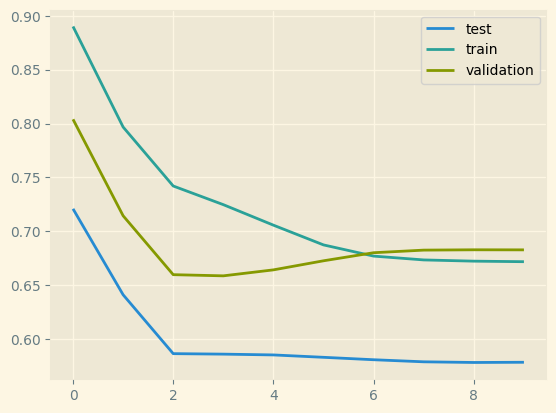

In [26]:
plt.plot(test_cost_avg, label="test")
plt.plot(train_cost_avg, label="train")
plt.plot(validation_cost_avg, label="validation")
plt.legend()
plt.show()